# Data Prep

The goal of this notebook is to prep the data for the alignment task.  This includes computing audio features and generating a query list.

In [3]:
import numpy as np
import librosa as lb
import os
import os.path
from pathlib import Path
import multiprocessing
from multiprocessing import Pool
import glob
from tqdm import tqdm

In [4]:
ANNOTATIONS_ROOT = Path('train_data/beat')
AUDIO_ROOT = ('Full_Alignment_Recordings')
FEATURES_ROOT = Path('features')
Scenario_1_files = 'Full_Alignment_Recordings/Scenario_1'
Scenario_2_files = 'Full_Alignment_Recordings/Scenario_2'
Scenario_3_files = 'Full_Alignment_Recordings/Scenario_3'
Scenario_4_files = 'Full_Alignment_Recordings/Scenario_4'

In [5]:
scenario1files = glob.glob(Scenario_1_files + "/*")
scenario2files = glob.glob(Scenario_2_files + "/*")
scenario3files = glob.glob(Scenario_3_files + "/*")
scenario4files = glob.glob(Scenario_4_files + "/*")
inFiles = []
for file in scenario1files:
    inFiles.append(file)
for file in scenario2files:
    inFiles.append(file)
for file in scenario3files:
    inFiles.append(file)
for file in scenario4files:
    inFiles.append(file)

print(len(inFiles))

8


In [6]:
if not os.path.exists(FEATURES_ROOT):
    os.mkdir(FEATURES_ROOT)

### Compute features on clean audio

First we compute features on the audio.

In [7]:
def compute_chroma_single(infile, outfile, sr = 22050, hop_length=512):
    print('loading', infile)
    y, sr = lb.core.load(infile, sr = sr)
    print(infile, 'loaded')
    # F = lb.feature.chroma_cens(y, sr=sr, hop_length=hop_length)
    print('computing features for', infile)
    F = lb.feature.chroma_cqt(y=y, sr=sr, hop_length=hop_length, norm=2)
    print('saving to', outfile,'...')
    np.save(outfile, F)
    print('saved')
    return

In [8]:
def compute_chroma_batch(filelist, outdir, n_cores):

    # prep inputs for parallelization
    inputs = []
    with open(filelist, 'r') as f:
        for line in f:
            relpath = line.strip()
            reldir, fileid = os.path.split(relpath)
            featdir = outdir / reldir
            featdir.mkdir(parents=True, exist_ok=True)
            featfile = (featdir / fileid).with_suffix('.npy')
            audiofile = relpath
            if os.path.exists(featfile):
                print(f"Skipping {featfile}")
            else:
                inputs.append((audiofile, featfile))

    # process files in parallel
    pool = multiprocessing.Pool(processes = n_cores)
    print('computing features...')
    pool.starmap(compute_chroma_single, inputs)
    print('done')
    
    return

In [9]:
compute_chroma_batch(Path("cfg_files/B_scenario.txt"), Path("scenario_feat"), 4) #set number of cores to 1 for debugging

Skipping scenario_feat/Sub_Alignment_Recordings/Scenario_1/sub_align_matching_30sec_recording1.npy
Skipping scenario_feat/Sub_Alignment_Recordings/Scenario_1/sub_align_matching_recording2.npy
Skipping scenario_feat/Sub_Alignment_Recordings/Scenario_2/sub_align_non_matching_30sec_recording1.npy
Skipping scenario_feat/Sub_Alignment_Recordings/Scenario_2/sub_align_non_matching_recording2.npy
Skipping scenario_feat/Sub_Alignment_Recordings/Scenario_3/sub_align_matching_spliced_recording1.npy
Skipping scenario_feat/Sub_Alignment_Recordings/Scenario_3/sub_align_matching_recording2.npy
Skipping scenario_feat/Sub_Alignment_Recordings/Scenario_4/sub_align_non_matching_spliced_recording1.npy
Skipping scenario_feat/Sub_Alignment_Recordings/Scenario_4/sub_align_non_matching_recording2.npy
computing features...
done


### Alignment

In [10]:
%matplotlib inline
%load_ext Cython

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import librosa as lb
import os.path
from pathlib import Path
import pickle
import multiprocessing
import time
import gc

In [12]:
%%cython
import numpy as np
cimport numpy as np
cimport cython

import sys
import time


DTYPE_INT32 = np.int32
ctypedef np.int32_t DTYPE_INT32_t

DTYPE_FLOAT = np.float64
ctypedef np.float64_t DTYPE_FLOAT_t

cdef DTYPE_FLOAT_t MAX_FLOAT = float('inf')

# careful, without bounds checking can mess up memory - also can't use negative indices I think (like x[-1])
@cython.boundscheck(False) # turn off bounds-checking for entire function
def DTW_Cost_To_AccumCostAndSteps(Cin, parameter):
    '''
    Inputs
        C: The cost Matrix
    '''


    '''
    Section for checking and catching errors in the inputs
    '''

    cdef np.ndarray[DTYPE_FLOAT_t, ndim=2] C
    try:
        C = np.array(Cin, dtype=DTYPE_FLOAT)
    except TypeError:
        print(bcolors.FAIL + "FAILURE: The type of the cost matrix is wrong - please pass in a 2-d numpy array" + bcolors.ENDC)
        return [-1, -1, -1]
    except ValueError:
        print(bcolors.FAIL + "FAILURE: The type of the elements in the cost matrix is wrong - please have each element be a float (perhaps you passed in a matrix of ints?)" + bcolors.ENDC)
        return [-1, -1, -1]

    cdef np.ndarray[np.uint32_t, ndim=1] dn
    cdef np.ndarray[np.uint32_t, ndim=1] dm
    cdef np.ndarray[DTYPE_FLOAT_t, ndim=1] dw
    # make sure dn, dm, and dw are setup
    # dn loading and exception handling
    if ('dn'  in parameter.keys()):
        try:

            dn = np.array(parameter['dn'], dtype=np.uint32)
        except TypeError:
            print(bcolors.FAIL + "FAILURE: The type of dn (row steps) is wrong - please pass in a 1-d numpy array that holds uint32s" + bcolors.ENDC)
            return [-1, -1, -1]
        except ValueError:
            print(bcolors.FAIL + "The type of the elements in dn (row steps) is wrong - please have each element be a uint32 (perhaps you passed a long?). You can specify this when making a numpy array like: np.array([1,2,3],dtype=np.uint32)" + bcolors.ENDC)
            return [-1, -1, -1]
    else:
        dn = np.array([1, 1, 0], dtype=np.uint32)
    # dm loading and exception handling
    if 'dm'  in parameter.keys():
        try:
            dm = np.array(parameter['dm'], dtype=np.uint32)
        except TypeError:
            print(bcolors.FAIL + "FAILURE: The type of dm (col steps) is wrong - please pass in a 1-d numpy array that holds uint32s" + bcolors.ENDC)
            return [-1, -1, -1]
        except ValueError:
            print(bcolors.FAIL + "FAILURE: The type of the elements in dm (col steps) is wrong - please have each element be a uint32 (perhaps you passed a long?). You can specify this when making a numpy array like: np.array([1,2,3],dtype=np.uint32)" + bcolors.ENDC)
            return [-1, -1, -1]
    else:
        print(bcolors.FAIL + "dm (col steps) was not passed in (gave default value [1,0,1]) " + bcolors.ENDC)
        dm = np.array([1, 0, 1], dtype=np.uint32)
    # dw loading and exception handling
    if 'dw'  in parameter.keys():
        try:
            dw = np.array(parameter['dw'], dtype=DTYPE_FLOAT)
        except TypeError:
            print(bcolors.FAIL + "FAILURE: The type of dw (step weights) is wrong - please pass in a 1-d numpy array that holds floats" + bcolors.ENDC)
            return [-1, -1, -1]
        except ValueError:
            print(bcolors.FAIL + "FAILURE:The type of the elements in dw (step weights) is wrong - please have each element be a float (perhaps you passed ints or a long?). You can specify this when making a numpy array like: np.array([1,2,3],dtype=np.float64)" + bcolors.ENDC)
            return [-1, -1, -1]
    else:
        dw = np.array([1, 1, 1], dtype=DTYPE_FLOAT)
        print(bcolors.FAIL + "dw (step weights) was not passed in (gave default value [1,1,1]) " + bcolors.ENDC)


    '''
    Section where types are given to the variables we're going to use
    '''
    # create matrices to store our results (D and E)
    cdef DTYPE_INT32_t numRows = C.shape[0] # only works with np arrays, use np.shape(x) will work on lists? want to force to use np though?
    cdef DTYPE_INT32_t numCols = C.shape[1]
    cdef DTYPE_INT32_t numDifSteps = np.size(dw)

    cdef unsigned int maxRowStep = max(dn)
    cdef unsigned int maxColStep = max(dm)

    cdef np.ndarray[np.uint32_t, ndim=2] steps = np.zeros((numRows,numCols), dtype=np.uint32)
    cdef np.ndarray[DTYPE_FLOAT_t, ndim=2] accumCost = np.ones((maxRowStep + numRows, maxColStep + numCols), dtype=DTYPE_FLOAT) * MAX_FLOAT

    cdef DTYPE_FLOAT_t bestCost
    cdef DTYPE_INT32_t bestCostIndex
    cdef DTYPE_FLOAT_t costForStep
    cdef unsigned int row, col
    cdef unsigned int stepIndex

    '''
    The start of the actual algorithm, now that all our variables are set up
    '''
    # initializing the cost matrix - depends on whether its subsequence DTW
    # essentially allow us to hop on the bottom anywhere (so could start partway through one of the signals)
    if parameter['SubSequence']:
        for col in range(numCols):
            accumCost[maxRowStep, col + maxColStep] = C[0, col]
    else:
        accumCost[maxRowStep, maxColStep] = C[0,0]

    # filling the accumulated cost matrix
    for row in range(maxRowStep, numRows + maxRowStep, 1):
        for col in range(maxColStep, numCols + maxColStep, 1):
            bestCost = accumCost[<unsigned int>row, <unsigned int>col] # initialize with what's there - so if is an entry point, then can start low
            bestCostIndex = 0
            # go through each step, find the best one
            for stepIndex in range(numDifSteps):
                #costForStep = accumCost[<unsigned int>(row - dn[<unsigned int>(stepIndex)]), <unsigned int>(col - dm[<unsigned int>(stepIndex)])] + dw[<unsigned int>(stepIndex)] * C[<unsigned int>(row - maxRowStep), <unsigned int>(col - maxColStep)]
                costForStep = accumCost[<unsigned int>((row - dn[(stepIndex)])), <unsigned int>((col - dm[(stepIndex)]))] + dw[stepIndex] * C[<unsigned int>(row - maxRowStep), <unsigned int>(col - maxColStep)]
                if costForStep < bestCost:
                    bestCost = costForStep
                    bestCostIndex = stepIndex
            # save the best cost and best cost index
            accumCost[row, col] = bestCost
            steps[<unsigned int>(row - maxRowStep), <unsigned int>(col - maxColStep)] = bestCostIndex

    # return the accumulated cost along with the matrix of steps taken to achieve that cost
    return [accumCost[maxRowStep:, maxColStep:], steps]

@cython.boundscheck(False) # turn off bounds-checking for entire function
def DTW_GetPath(np.ndarray[DTYPE_FLOAT_t, ndim=2] accumCost, np.ndarray[np.uint32_t, ndim=2] stepsForCost, parameter):
    '''

    Parameter should have: 'dn', 'dm', 'dw', 'SubSequence'
    '''

    cdef np.ndarray[unsigned int, ndim=1] dn
    cdef np.ndarray[unsigned int, ndim=1] dm
    cdef np.uint8_t subseq
    cdef np.int32_t startCol # added
    # make sure dn, dm, and dw are setup
    if ('dn'  in parameter.keys()):
        dn = parameter['dn']
    else:
        dn = np.array([1, 1, 0], dtype=DTYPE_INT32)
    if 'dm'  in parameter.keys():
        dm = parameter['dm']
    else:
        dm = np.array([1, 0, 1], dtype=DTYPE_INT32)
    if 'SubSequence' in parameter.keys():
        subseq = parameter['SubSequence']
    else:
        subseq = 0

    # added START
    if 'startCol' in parameter.keys():
        startCol = parameter['startCol']
    else:
        startCol = -1
    # added END

    cdef np.uint32_t numRows
    cdef np.uint32_t numCols
    cdef np.uint32_t curRow
    cdef np.uint32_t curCol
    cdef np.uint32_t endCol
    cdef DTYPE_FLOAT_t endCost

    numRows = accumCost.shape[0]
    numCols = accumCost.shape[1]

    # either start at the far corner (non sub-sequence)
    # or start at the lowest cost entry in the last row (sub-sequence)
    # where all of the signal along the row has been used, but only a
    # sub-sequence of the signal along the columns has to be used
    curRow = numRows - 1
    if subseq:
        curCol = np.argmin(accumCost[numRows - 1, :])
    else:
        curCol = numCols - 1

    # added - if specified, overrides above
    if startCol >= 0:
        curCol = startCol

    endCol = curCol
    endCost = accumCost[curRow, curCol]

    cdef np.uint32_t curRowStep
    cdef np.uint32_t curColStep
    cdef np.uint32_t curStepIndex


    cdef np.ndarray[np.uint32_t, ndim=2] path = np.zeros((2, numRows + numCols), dtype=np.uint32) # make as large as could need, then chop at the end
    path[0, 0] = curRow
    path[1, 0] = curCol

    cdef np.uint32_t stepsInPath = 1 # starts at one, we add in one before looping
    cdef np.uint32_t stepIndex = 0
    cdef np.int8_t done = (subseq and curRow == 0) or (curRow == 0 and curCol == 0) 
    while not done:
        if accumCost[curRow, curCol] == MAX_FLOAT:
            print('A path is not possible')
            break
        
        # you're done if you've made it to the bottom left (non sub-sequence)
        # or just the bottom (sub-sequence)
        # find the step size
        curStepIndex = stepsForCost[curRow, curCol]
        curRowStep = dn[curStepIndex]
        curColStep = dm[curStepIndex]
        # backtrack by 1 step
        curRow = curRow - curRowStep
        curCol = curCol - curColStep
        # add your new location onto the path
        path[0, stepsInPath] = curRow
        path[1, stepsInPath] = curCol
        stepsInPath = stepsInPath + 1
        # check to see if you're done
        done = (subseq and curRow == 0) or (curRow == 0 and curCol == 0)

    # reverse the path (a matrix with two rows) and return it
    return [np.fliplr(path[:, 0:stepsInPath]), endCol, endCost]

class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

In [13]:
def alignDTW(featfile1, featfile2, steps, weights, downsample, outfile = None, profile = False, subsequence=False):

    F1 = np.load(featfile1, allow_pickle=False) # 12 x N
    F2 = np.load(featfile2, allow_pickle=False) # 12 x M
    if subsequence: 
        times = []
        times.append(time.time())
        C = 1 - F1[:,0::downsample].T @ F2[:,0::downsample] # cos distance metric
        times.append(time.time())
        dn = steps[:,0].astype(np.uint32)
        dm = steps[:,1].astype(np.uint32)
        parameters = {'dn': dn, 'dm': dm, 'dw': weights, 'SubSequence': True}
        [D, s] = DTW_Cost_To_AccumCostAndSteps(C, parameters)
        times.append(time.time())
        [wp, endCol, endCost] = DTW_GetPath(D, s, parameters)
        times.append(time.time())
        if outfile:
            pickle.dump(wp, open(outfile, 'wb'))
    else: 
        if max(F1.shape[1], F2.shape[1]) / min(F1.shape[1], F2.shape[1]) >= 2: # no valid path possible
            if outfile:
                pickle.dump(None, open(outfile, 'wb'))
            return None
        times = []
        times.append(time.time())
        C = 1 - F1[:,0::downsample].T @ F2[:,0::downsample] # cos distance metric
        times.append(time.time())

        dn = steps[:,0].astype(np.uint32)
        dm = steps[:,1].astype(np.uint32)
        parameters = {'dn': dn, 'dm': dm, 'dw': weights, 'SubSequence': False}
        [D, s] = DTW_Cost_To_AccumCostAndSteps(C, parameters)
        times.append(time.time())
        [wp, endCol, endCost] = DTW_GetPath(D, s, parameters)
        times.append(time.time())
        if outfile:
            pickle.dump(wp, open(outfile, 'wb'))

    if profile:
        return wp, np.diff(times)
    else:
        return wp, D, C, s, parameters

In [14]:
def Bmat_from_Dmat(D, steps, weights):
    B = np.dstack((np.zeros_like(D),np.zeros_like(D)))
    for i in tqdm(range(D.shape[0])):
        for j in range(D.shape[1]):
            bestCost = np.infty
            bestStep = -1
            for stepnum in range(steps.shape[0]):    
                if i-steps[stepnum,0] < 0:
                    pass                       
                elif j-steps[stepnum,1] < 0:
                    pass
                else:
                    tempCost = D[i-steps[stepnum,0], j-steps[stepnum,1]]
                    if tempCost < bestCost:
                        bestCost = tempCost
                        bestStep = stepnum
            B[i,j] = [i-steps[bestStep,0], j-steps[bestStep, 1]]
    return B

In [15]:
def Bpoint_from_Dpoint(D, steps, weights):
    bestCost = np.infty
    bestStep = -1
    for stepnum in range(steps.shape[0]):    
        if i-steps[stepnum,0] < 0:
            pass                       
        elif j-steps[stepnum,1] < 0:
            pass
        else:
            tempCost = D[i-steps[stepnum,0], j-steps[stepnum,1]]
            if tempCost < bestCost:
                bestCost = tempCost
                bestStep = stepnum
    B[i,j] = [i-steps[bestStep,0], j-steps[bestStep, 1]]
    return B

## Idea 1 -- Visualization of the path and D matrix

### Full Alignment

In [16]:
scenario1Features = glob.glob("scenario_feat/Full_Alignment_Recordings/Scenario_1" + "/*.npy")
print(scenario1Features)
scenario2Features = glob.glob("scenario_feat/Full_Alignment_Recordings/Scenario_2" + "/*.npy")
scenario3Features = glob.glob("scenario_feat/Full_Alignment_Recordings/Scenario_3" + "/*.npy")
scenario4Features = glob.glob("scenario_feat/Full_Alignment_Recordings/Scenario_4" + "/*.npy")
steps = np.array([1,1,1,2,2,1]).reshape((-1,2))
weights = np.array([2,3,3])
downsample = 1

print('Scenario 1')
wp1, D1, C1, s1, parameters1 = (alignDTW(scenario1Features[0], scenario1Features[1], steps, weights, downsample))
print('Scenario 2')
wp2, D2, C2, s2, parameters2 = (alignDTW(scenario2Features[0], scenario2Features[1], steps, weights, downsample))
print('Scenario 3')
wp3, D3, C3, s3, parameters3  = (alignDTW(scenario3Features[0], scenario3Features[1], steps, weights, downsample))
print('Scenario 4')
wp4, D4, C4, s4, parameters4 = (alignDTW(scenario4Features[0], scenario4Features[1], steps, weights, downsample))

['scenario_feat/Full_Alignment_Recordings/Scenario_1/full_align_matching_recording2.npy', 'scenario_feat/Full_Alignment_Recordings/Scenario_1/full_align_matching_recording1.npy']
Scenario 1
Scenario 2
Scenario 3
Scenario 4


In [15]:
# print(wp1.shape)

In [16]:
# B1 = Bmat_from_Dmat(D1, steps, weights)
# np.set_printoptions(threshold=np.inf, linewidth=np.inf)

In [17]:
# B2 = Bmat_from_Dmat(D2, steps, weights)
# np.set_printoptions(threshold=np.inf, linewidth=np.inf)

In [18]:
# B3 = Bmat_from_Dmat(D3, steps, weights)

In [19]:
# B4 = Bmat_from_Dmat(D4, steps, weights)

In [20]:
# # np.save(Path('scenario_feat/Full_Alignment_Recordings/Scenario_1/Backtraces/B1.npy'), B1)
# # np.save(Path('scenario_feat/Full_Alignment_Recordings/Scenario_1/Costs/D1.npy'), D1)
# # np.save(Path('scenario_feat/Full_Alignment_Recordings/Scenario_2/Backtraces/B2.npy'), B2)
# # np.save(Path('scenario_feat/Full_Alignment_Recordings/Scenario_2/Costs/D2.npy'), D2)
# # np.save(Path('scenario_feat/Full_Alignment_Recordings/Scenario_3/Backtraces/B3.npy'), B3)
# # np.save(Path('scenario_feat/Full_Alignment_Recordings/Scenario_3/Costs/D3.npy'), D3)
# # np.save(Path('scenario_feat/Full_Alignment_Recordings/Scenario_4/Backtraces/B4.npy'), B4)
# # np.save(Path('scenario_feat/Full_Alignment_Recordings/Scenario_4/Costs/D4.npy'), D4)
# # np.save(Path('scenario_feat/Full_Alignment_Recordings/Scenario_1/Costs/C1.npy'), C1)
# # np.save(Path('scenario_feat/Full_Alignment_Recordings/Scenario_2/Costs/C2.npy'), C2)
# # np.save(Path('scenario_feat/Full_Alignment_Recordings/Scenario_3/Costs/C3.npy'), C3)
# # np.save(Path('scenario_feat/Full_Alignment_Recordings/Scenario_4/Costs/C4.npy'), C4)

# np.save('scenario_feat/Full_Alignment_Recordings/Scenario_1/Backtraces/wp1.npy', wp1)
# np.save('scenario_feat/Full_Alignment_Recordings/Scenario_2/Backtraces/wp2.npy', wp2)
# np.save('scenario_feat/Full_Alignment_Recordings/Scenario_3/Backtraces/wp3.npy', wp3)
# np.save('scenario_feat/Full_Alignment_Recordings/Scenario_4/Backtraces/wp4.npy', wp4)

In [21]:
# wp1

In [22]:
# D1.shape

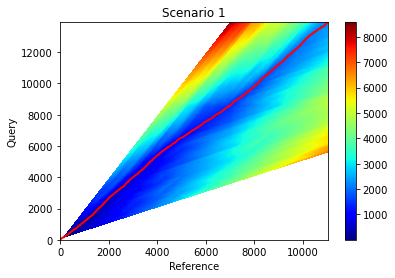

In [23]:
plt.xlabel('Reference')
plt.ylabel('Query')
x,y = wp1[0], wp1[1]
plt.plot(y,x, color='red', markersize=1, linewidth=2)
plt.imshow(D1, origin = 'lower', cmap='jet', aspect='auto')
plt.title('Scenario 1')
plt.colorbar()

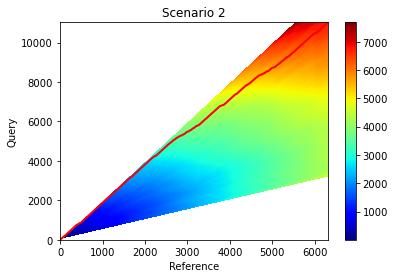

In [24]:
plt.xlabel('Reference')
plt.ylabel('Query')
x,y = wp2[0], wp2[1]
plt.plot(y,x, color='red', markersize=1, linewidth=2)
plt.imshow(D2, origin = 'lower', cmap='jet', aspect='auto')
plt.title('Scenario 2')
plt.colorbar()

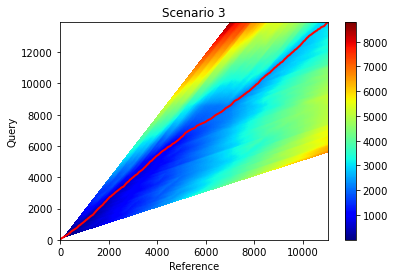

In [25]:
plt.xlabel('Reference')
plt.ylabel('Query')
x,y = wp3[0], wp3[1]
plt.plot(y,x, color='red', markersize=1, linewidth=2)
plt.imshow(D3, origin = 'lower', cmap='jet', aspect='auto')
plt.title('Scenario 3')
plt.colorbar()

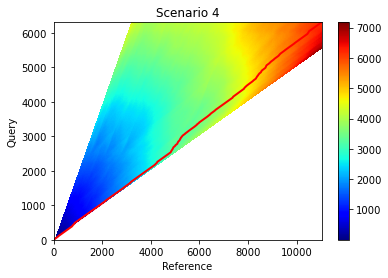

In [26]:
plt.xlabel('Reference')
plt.ylabel('Query')
x,y = wp4[0], wp4[1]
plt.plot(y,x, color='red', markersize=1, linewidth=2)
plt.imshow(D4, origin = 'lower', cmap='jet', aspect='auto')
plt.title('Scenario 4')
plt.colorbar()

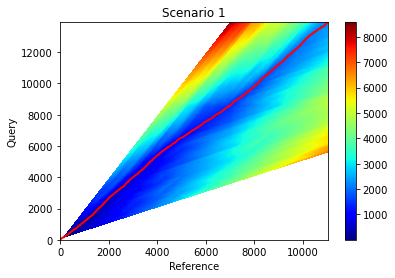

In [27]:
plt.xlabel('Reference')
plt.ylabel('Query')
x,y = wp1[0], wp1[1]
plt.plot(y,x, color='red', markersize=1, linewidth=2)
plt.imshow(D1, origin = 'lower', cmap='jet', aspect='auto')
plt.title('Scenario 1')
plt.colorbar()

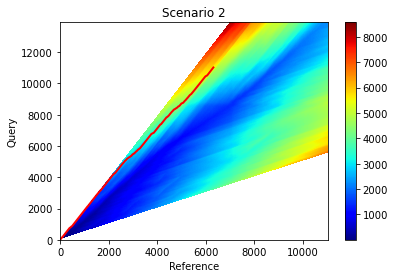

In [28]:
plt.xlabel('Reference')
plt.ylabel('Query')
x,y = wp2[0], wp2[1]
plt.plot(y,x, color='red', markersize=1, linewidth=2)
plt.imshow(D1, origin = 'lower', cmap='jet', aspect='auto')
plt.title('Scenario 2')
plt.colorbar()

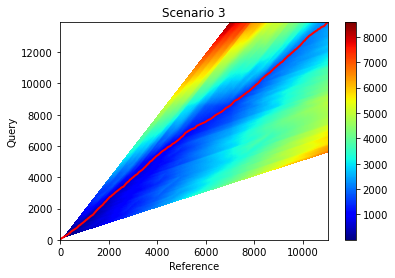

In [29]:
plt.xlabel('Reference')
plt.ylabel('Query')
x,y = wp3[0], wp3[1]
plt.plot(y,x, color='red', markersize=1, linewidth=2)
plt.imshow(D1, origin = 'lower', cmap='jet', aspect='auto')
plt.title('Scenario 3')
plt.colorbar()

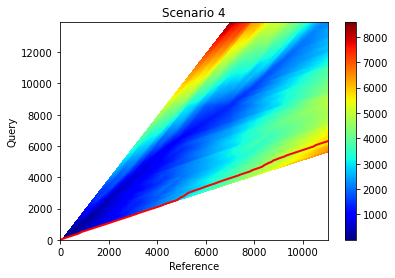

In [30]:
plt.xlabel('Reference')
plt.ylabel('Query')
x,y = wp4[0], wp4[1]
plt.plot(y,x, color='red', markersize=1, linewidth=2)
plt.imshow(D1, origin = 'lower', cmap='jet', aspect='auto')
plt.title('Scenario 4')
plt.colorbar()

### Idea 2 -- Backtrace voting

In [36]:
sampling_interval = 50

def backtrace_vote(point):
    r, c = point
    if D1[r, c] != np.inf:
        wp_tmp, _, _ = DTW_GetPath(D1[:r+1, :c+1], s1, parameters1)
        return [(x, y) for x, y in wp_tmp.T]
    return []

def update_votes(vote_lists, D):
    votes = np.zeros(D.shape)
    for vote_list in vote_lists:
        for i, j in vote_list:
            votes[i, j] += 1
    return votes

In [37]:
if __name__ == '__main__':
    points_to_process = [(r, c) for r in range(0, D1.shape[0], sampling_interval) 
                                 for c in range(0, D1.shape[1], sampling_interval) 
                                 if D1[r, c] != np.inf]
    
    with multiprocessing.Pool(processes=multiprocessing.cpu_count()) as pool:
        result_lists = pool.map(backtrace_vote, points_to_process)
        votes_1 = update_votes(result_lists, D1)

    print("Sparse sampling backtrace voting complete.")

Sparse sampling backtrace voting complete.


In [43]:
from scipy.ndimage.filters import gaussian_filter

def plot_vote(votes):

    plt.figure(figsize=(10, 10))

    blurred_votes = gaussian_filter(votes, sigma=10)
   
    # im = plt.imshow(votes, cmap='hot', interpolation='nearest', aspect='auto', origin='lower')
    # plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.contourf(np.log(blurred_votes+1))
    plt.colorbar()
   
    plt.title('Heatmap of Votes')
    plt.xlabel('Query Audio')
    plt.ylabel('Reference Audio')

    plt.savefig('heatmap_of_votes.png', format='png', dpi=300)
    plt.show()

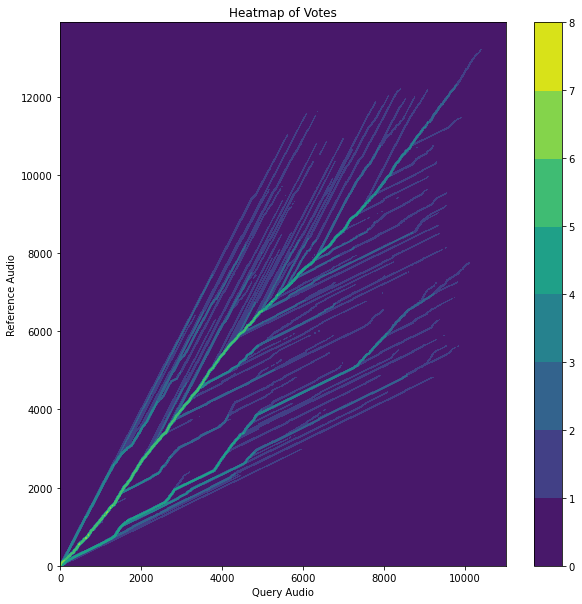

In [44]:
plot_vote(votes_1)

Sparse sampling backtrace voting complete.


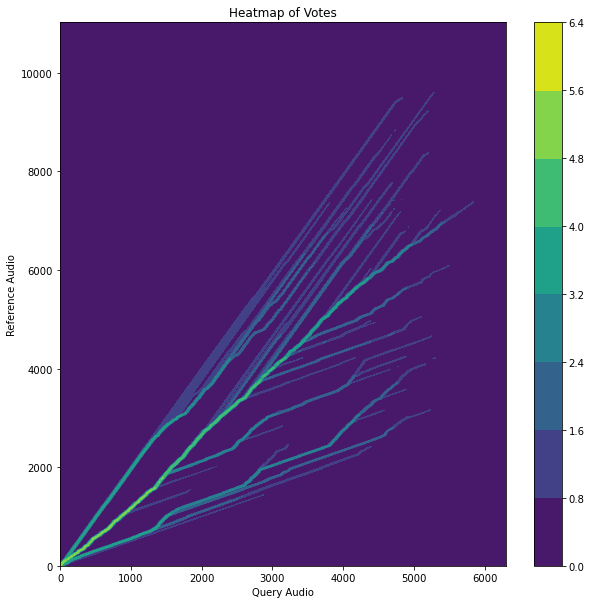

In [45]:
if __name__ == '__main__':
    points_to_process = [(r, c) for r in range(0, D2.shape[0], sampling_interval) 
                                 for c in range(0, D2.shape[1], sampling_interval) 
                                 if D2[r, c] != np.inf]
    
    with multiprocessing.Pool(processes=multiprocessing.cpu_count()) as pool:
        result_lists = pool.map(backtrace_vote, points_to_process)
        votes_2 = update_votes(result_lists, D2)

    print("Sparse sampling backtrace voting complete.")

plot_vote(votes_2)

Sparse sampling backtrace voting complete.


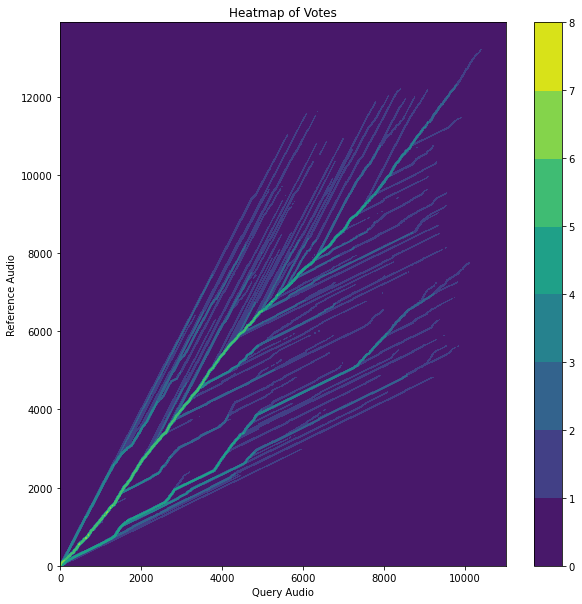

In [46]:
if __name__ == '__main__':
    points_to_process = [(r, c) for r in range(0, D3.shape[0], sampling_interval) 
                                 for c in range(0, D3.shape[1], sampling_interval) 
                                 if D3[r, c] != np.inf]
    
    with multiprocessing.Pool(processes=multiprocessing.cpu_count()) as pool:
        result_lists = pool.map(backtrace_vote, points_to_process)
        votes_3 = update_votes(result_lists, D3)

    print("Sparse sampling backtrace voting complete.")

plot_vote(votes_3)

In [47]:
if __name__ == '__main__':
    points_to_process = [(r, c) for r in range(0, D4.shape[0], sampling_interval) 
                                 for c in range(0, D4.shape[1], sampling_interval) 
                                 if D4[r, c] != np.inf]

    with multiprocessing.Pool(processes=multiprocessing.cpu_count()) as pool:
        result_lists = pool.map(backtrace_vote, points_to_process)
        votes_4 = update_votes(result_lists, D4)

    print("Sparse sampling backtrace voting complete.")

plot_vote(votes_4)

Sparse sampling backtrace voting complete.


### Idea 4 -- Valley Width

In [24]:
def analyze_valleys_on_path(D, optimal_path, valley_length=50):

    path_indices = [int(len(optimal_path) * fraction) for fraction in [1/6, 2/6, 3/6, 4/6, 5/6]]
    
    valley_data = []
    
    for index in path_indices:
        # Assuming the optimal path is in the format [(i0, j0), (i1, j1), ..., (iN, jN)]
        point = optimal_path[index]
        valley_points = plot_single_valley(D, point, length=valley_length)
        valley_width = calc_valley_width(valley_points)
        
        valley_data.append({
            'point': point,
            'valley_points': valley_points,
            'valley_width': valley_width
        })
    
    return valley_data
def plot_single_valley(D, point, length=100):
    i, j = point
    valley_points = []
    for k in range(-length//2, length//2):
        if 0 <= i+k < D.shape[0] and 0 <= j-k < D.shape[1]:
            valley_points.append(D[i+k, j-k])
    return np.array(valley_points)

def calc_valley_width(points):
    mean = np.min([np.mean(points), points[0], points[-1]])
    width = len(points) - np.sum((points - mean) > 0)
    return width/len(points)

def visualize_valleys(valley_data):
    
    fig, axes = plt.subplots(1, 5, figsize=(20, 5))
    fig.suptitle('Valleys along the Optimal Path')

    for ax, data in zip(axes, valley_data):
        
        point = data['point']
        valley_points = data['valley_points']
        valley_width = data['valley_width']

        # Plot the valley points on the axis
        ax.plot(valley_points, marker='o')
        average_width = np.min([np.mean(valley_points), valley_points[0], valley_points[-1]])
        ax.axhline(y=average_width, color='r', linestyle='--', label=f'Average Width: {average_width:.2f}')
        ax.set_title(f'Width: {valley_width}')
        ax.set_xlabel('Points along the diagonal')
        ax.set_ylabel('D values')

    plt.tight_layout()
    plt.savefig('Valley_width.png', format='png', dpi=300)
    plt.show()

In [25]:
valley_data_1 = analyze_valleys_on_path(D1, wp1.T)

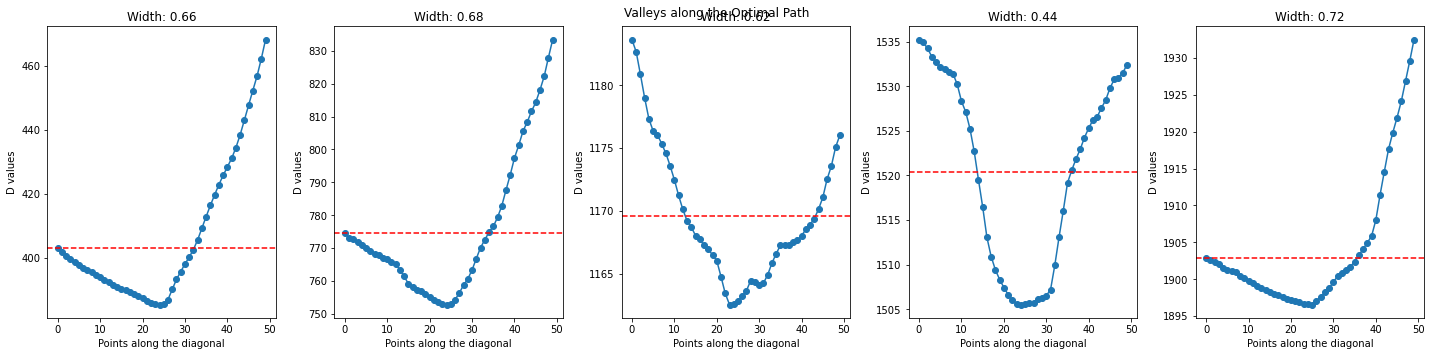

In [26]:
visualize_valleys(valley_data_1)

In [27]:
valley_data_2 = analyze_valleys_on_path(D2, wp2.T)

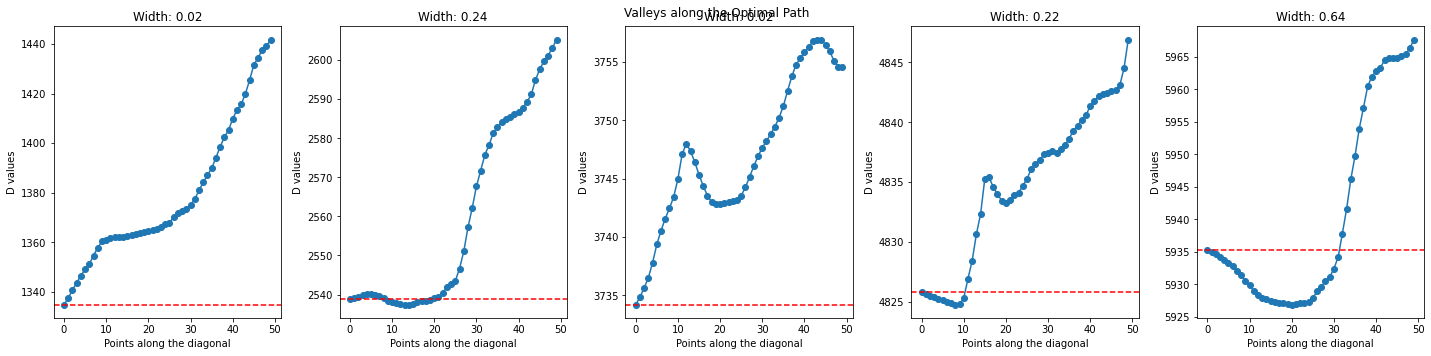

In [28]:
visualize_valleys(valley_data_2)

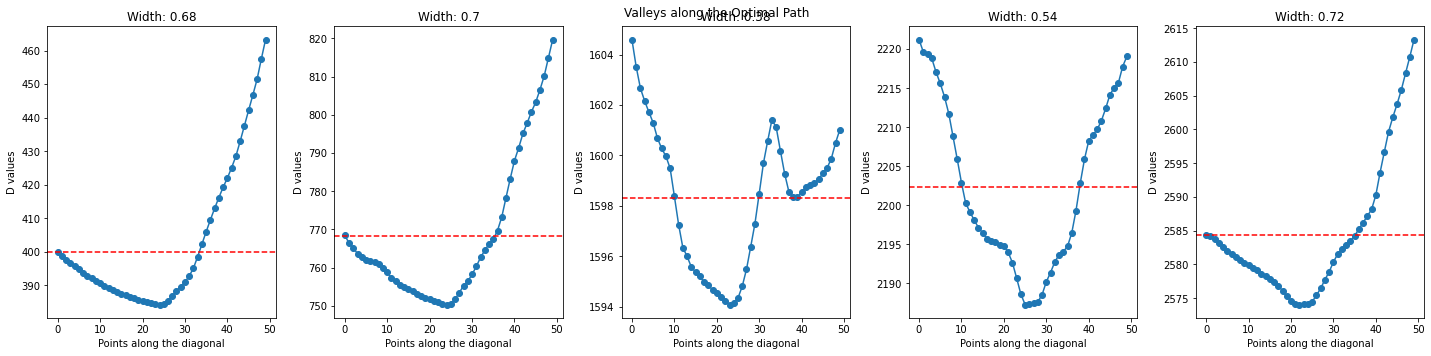

In [29]:
valley_data_3 = analyze_valleys_on_path(D3, wp3.T)
visualize_valleys(valley_data_3)

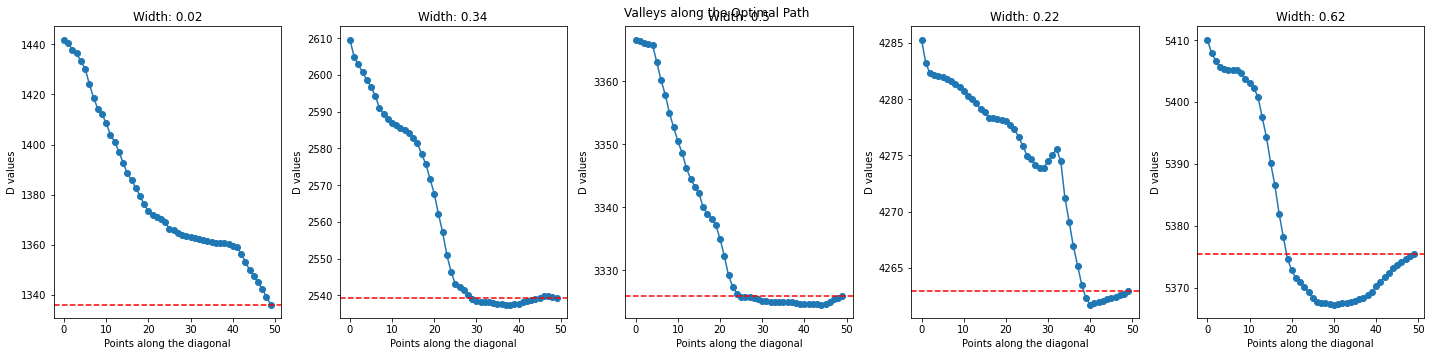

In [30]:
valley_data_4 = analyze_valleys_on_path(D4, wp4.T)
visualize_valleys(valley_data_4)

In [20]:
def compute_valley_width_at_point(args):
    D, point, valley_length = args
    points = plot_single_valley(D, point, valley_length)
    return calc_valley_width(points)


def select_equidistant_points(path, num_points):
    return [path[int(len(path) * i / num_points)] for i in range(1, num_points)]

In [21]:
from scipy.signal import savgol_filter

selected_points_1 = select_equidistant_points(wp1.T, 301)
args_list_1 = [(D1, point, 300) for point in selected_points_1]


In [22]:
if __name__ == "__main__":
    with Pool(processes=multiprocessing.cpu_count()) as pool:
        valley_widths_1 = pool.map(compute_valley_width_at_point, args_list_1)

average_width_1 = np.mean(valley_widths_1)

/home/pliu/ttemp/ttemp/envs/E207_project/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in subtract
/home/pliu/ttemp/ttemp/envs/E207_project/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in greater
/home/pliu/ttemp/ttemp/envs/E207_project/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in subtract
/home/pliu/ttemp/ttemp/envs/E207_project/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in greater
/home/pliu/ttemp/ttemp/envs/E207_project/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in subtract
/home/pliu/ttemp/ttemp/envs/E207_project/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in greater
/home/pliu/ttemp/ttemp/envs/E207_project/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning

In [23]:
from matplotlib.ticker import AutoMinorLocator

def plot_smooth(valley_width, average_width):

    smoothed_valleys = savgol_filter(valley_width, window_length=21, polyorder=3)

    plt.figure(figsize=(12, 6))
    plt.plot(smoothed_valleys, label='Smoothed Valley Widths', color='navy')
    plt.axhline(y=average_width, color='crimson', linestyle='--', label=f'Average Width: {average_width:.2f}')


    plt.title('Change of Valley Widths Along the Optimal Path')
    plt.xlabel('Point Index')
    plt.ylabel('Valley Width')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.minorticks_on()
    plt.gca().xaxis.set_minor_locator(AutoMinorLocator(2))
    plt.gca().yaxis.set_minor_locator(AutoMinorLocator(2))
    plt.legend()
    plt.tight_layout()
    
    plt.savefig('valley_widths_plot.pdf', format='pdf', dpi=300)
    plt.show()


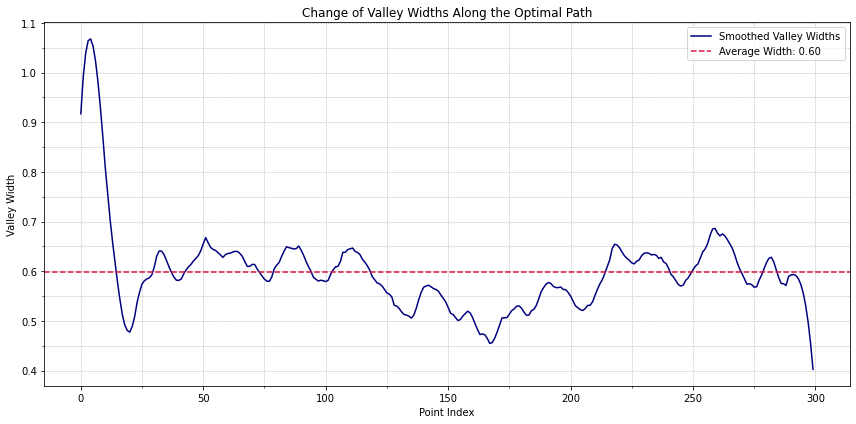

In [24]:
plot_smooth(valley_widths_1, average_width_1)

In [25]:
selected_points_2 = select_equidistant_points(wp2.T, 301)
args_list_2 = [(D2, point, 300) for point in selected_points_2]


In [26]:
if __name__ == "__main__":
    with Pool(processes=multiprocessing.cpu_count()) as pool:
        valley_widths_2 = pool.map(compute_valley_width_at_point, args_list_2)

average_width_2 = np.mean(valley_widths_2)

/home/pliu/ttemp/ttemp/envs/E207_project/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in subtract
/home/pliu/ttemp/ttemp/envs/E207_project/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in greater
/home/pliu/ttemp/ttemp/envs/E207_project/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in subtract
/home/pliu/ttemp/ttemp/envs/E207_project/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in greater
/home/pliu/ttemp/ttemp/envs/E207_project/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in subtract
/home/pliu/ttemp/ttemp/envs/E207_project/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in greater
/home/pliu/ttemp/ttemp/envs/E207_project/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning

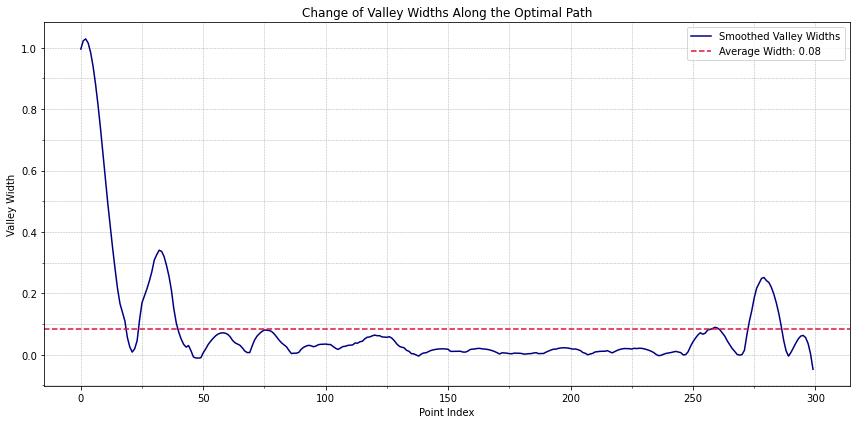

In [27]:
plot_smooth(valley_widths_2, average_width_2)

In [28]:
selected_points_3 = select_equidistant_points(wp3.T, 301)
args_list_3 = [(D3, point, 300) for point in selected_points_3]


In [29]:
if __name__ == "__main__":
    with Pool(processes=multiprocessing.cpu_count()) as pool:
        valley_widths_3 = pool.map(compute_valley_width_at_point, args_list_3)

average_width_3 = np.mean(valley_widths_3)

/home/pliu/ttemp/ttemp/envs/E207_project/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in subtract
/home/pliu/ttemp/ttemp/envs/E207_project/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in greater
/home/pliu/ttemp/ttemp/envs/E207_project/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in subtract
/home/pliu/ttemp/ttemp/envs/E207_project/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in greater
/home/pliu/ttemp/ttemp/envs/E207_project/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in subtract
/home/pliu/ttemp/ttemp/envs/E207_project/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in greater
/home/pliu/ttemp/ttemp/envs/E207_project/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning

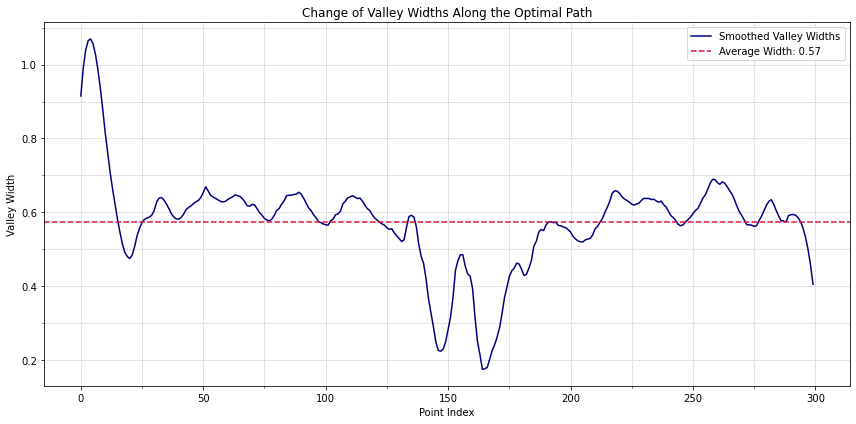

In [30]:
plot_smooth(valley_widths_3, average_width_3)

In [33]:
selected_points_4 = select_equidistant_points(wp4.T, 301)
args_list_4 = [(D4, point, 300) for point in selected_points_4]

In [34]:
if __name__ == "__main__":
    with Pool(processes=multiprocessing.cpu_count()) as pool:
        valley_widths_4 = pool.map(compute_valley_width_at_point, args_list_4)

average_width_4 = np.mean(valley_widths_4)

/home/pliu/ttemp/ttemp/envs/E207_project/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in subtract
/home/pliu/ttemp/ttemp/envs/E207_project/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in greater
/home/pliu/ttemp/ttemp/envs/E207_project/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in subtract
/home/pliu/ttemp/ttemp/envs/E207_project/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in greater
/home/pliu/ttemp/ttemp/envs/E207_project/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in subtract
/home/pliu/ttemp/ttemp/envs/E207_project/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in greater
/home/pliu/ttemp/ttemp/envs/E207_project/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning

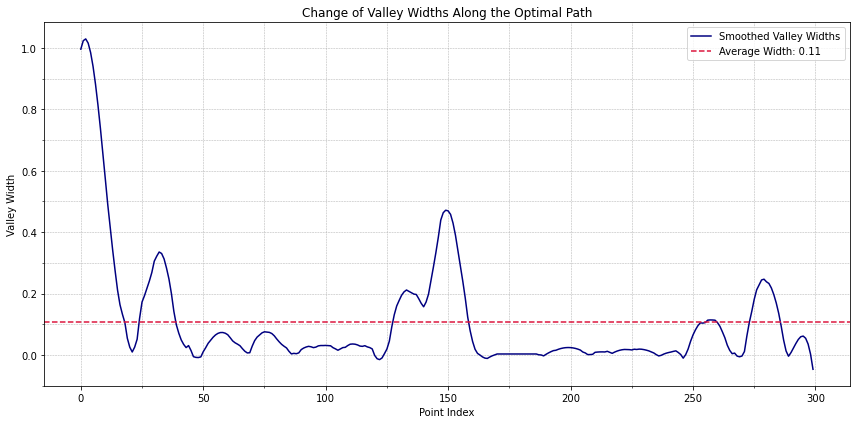

In [35]:
plot_smooth(valley_widths_4, average_width_4)

# Subsequence Alignment

## Idea 1: Visualizing D and B

In [ ]:
scenario1Features = glob.glob("scenario_feat/Sub_Alignment_Recordings/Scenario_1" + "/*")
scenario2Features = glob.glob("scenario_feat/Sub_Alignment_Recordings/Scenario_2" + "/*")
scenario3Features = glob.glob("scenario_feat/Sub_Alignment_Recordings/Scenario_3" + "/*")
scenario4Features = glob.glob("scenario_feat/Sub_Alignment_Recordings/Scenario_4" + "/*")
steps = np.array([1,1,1,2,2,1]).reshape((-1,2))
weights = np.array([2,3,3])
downsample = 1
print('Scenario 1')
wp1, D1, C1, s1, parameters1 = (alignDTW(scenario1Features[0], scenario1Features[1], steps, weights, downsample, subsequence=True))
print('Scenario 2')
wp2, D2, C2, s2, parameters2 = (alignDTW(scenario2Features[0], scenario2Features[1], steps, weights, downsample, subsequence=True))
print('Scenario 3')
wp3, D3, C3, s3, parameters3  = (alignDTW(scenario3Features[0], scenario3Features[1], steps, weights, downsample, subsequence=True))
print('Scenario 4')
wp4, D4, C4, s4, parameters4 = (alignDTW(scenario4Features[0], scenario4Features[1], steps, weights, downsample, subsequence=True))

Scenario 1
Scenario 2


A path is not possible
Scenario 3
Scenario 4
A path is not possible


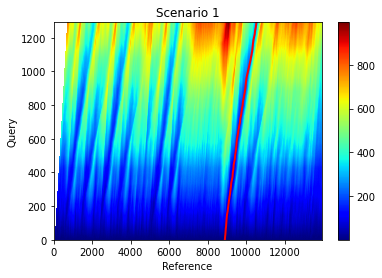

In [ ]:
plt.xlabel('Reference')
plt.ylabel('Query')
x,y = wp1[0], wp1[1]
plt.plot(y,x, color='red', markersize=1, linewidth=2)
plt.imshow(D1, origin = 'lower', cmap='jet', aspect='auto')
plt.title('Scenario 1')
plt.colorbar()

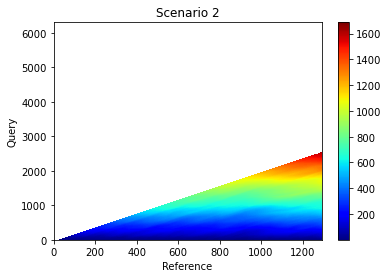

In [ ]:
plt.xlabel('Reference')
plt.ylabel('Query')
x,y = wp2[0], wp2[1]
plt.plot(y,x, color='red', markersize=1, linewidth=2)
plt.imshow(D2, origin = 'lower', cmap='jet', aspect='auto')
plt.title('Scenario 2')
plt.colorbar()

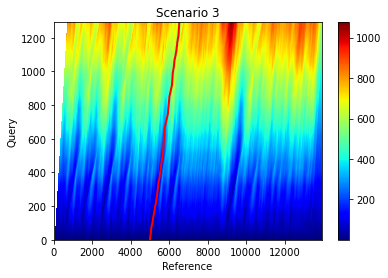

In [ ]:
plt.xlabel('Reference')
plt.ylabel('Query')
x,y = wp3[0], wp3[1]
plt.plot(y,x, color='red', markersize=1, linewidth=2)
plt.imshow(D3, origin = 'lower', cmap='jet', aspect='auto')
plt.title('Scenario 3')
plt.colorbar()

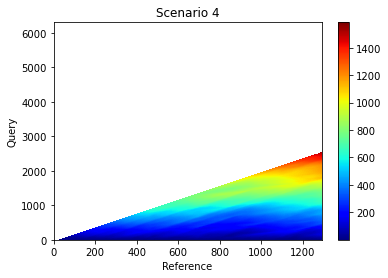

In [ ]:
plt.xlabel('Reference')
plt.ylabel('Query')
x,y = wp4[0], wp4[1]
plt.plot(y,x, color='red', markersize=1, linewidth=2)
plt.imshow(D4, origin = 'lower', cmap='jet', aspect='auto')
plt.title('Scenario 4')
plt.colorbar()